## Affective Polarization across European Parliaments

This notebook contains the code used in the experiments in the arxiv paper "Affective Polarization across European Parliaments". The data is available here: clarin_to_be_added...

The notebook uses data produced in the other scripts: s0_metadata_prep.py, s1_sentiment.py and s2_mentions.py

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
import statsmodels.api as sm

In [70]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

full_df = pd.DataFrame()

for parliament in parliaments:
    df = pd.read_csv('../../data/parliaments/' + parliament + '/metasent_' + parliament + '.csv')[['Party_status', 'sentiment']]
    
    df['Parliament'] = parliament
    
    full_df = pd.concat([full_df, df])

In [71]:
full_df = full_df.dropna()

In [72]:
full_df.groupby('Parliament')['sentiment'].mean()

Parliament
DK   -0.301462
ES   -0.276254
FR   -0.305410
PL   -0.343387
RS   -0.476967
UA   -0.346930
Name: sentiment, dtype: float64

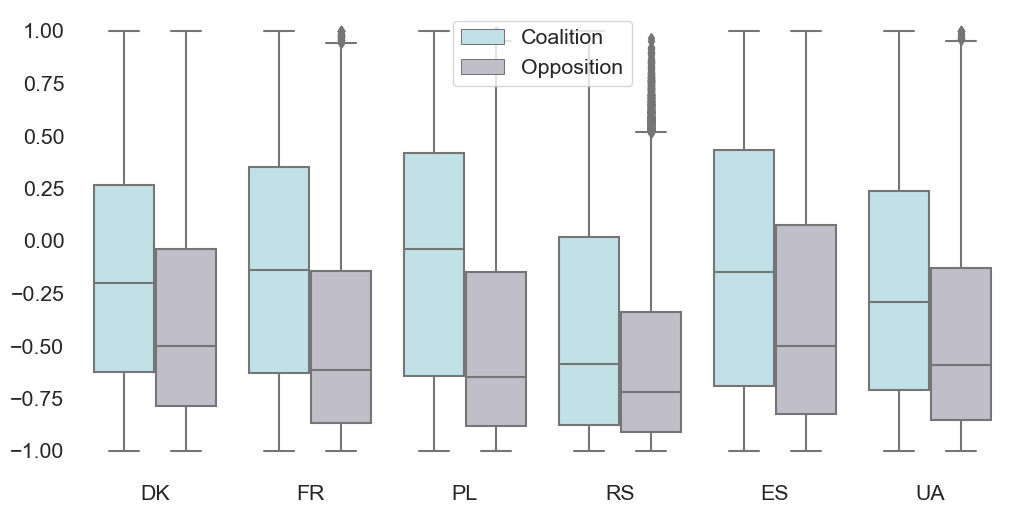

In [6]:
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.4)
sns.set_style('white')

ax = sns.boxplot(data=full_df, x="Parliament", y="sentiment", hue="Party_status", hue_order=['Coalition', 'Opposition'],
           palette=('#BBE5ED', '#BFBCCB'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(loc='upper center')



plt.xlabel('')
plt.ylabel('')


plt.savefig('./paper_figures/boxplot1.png', dpi=200)


plt.show()



In [5]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'UA', 'ES']

for parliament in parliaments:
    df = pd.read_csv('../../data/parliaments/' + parliament + '/metasent_' + parliament + '.csv')[['Party_status', 'sentiment']]
    
    df['Parliament'] = parliament
    
    x = df[df['Party_status'] == 'Coalition']['sentiment'].values
    y = df[df['Party_status'] == 'Opposition']['sentiment'].values
    print("Parliament: ", parliament)
    print("Coalition vs. Opposition: ", ks_2samp(x, y))
    
    print("Coalition quantiles: ", df[df['Party_status'] == 'Coalition']['sentiment'].quantile([0.25, 0.5, 0.75]))
    print("Opposition quantiles: ", df[df['Party_status'] == 'Opposition']['sentiment'].quantile([0.25, 0.5, 0.75]))

Parliament:  DK
Coalition vs. Opposition:  KstestResult(statistic=0.17938303012418855, pvalue=0.0)
Coalition quantiles:  0.25   -0.626465
0.50   -0.199829
0.75    0.264221
Name: sentiment, dtype: float64
Opposition quantiles:  0.25   -0.788574
0.50   -0.502930
0.75   -0.038330
Name: sentiment, dtype: float64
Parliament:  FR
Coalition vs. Opposition:  KstestResult(statistic=0.2646694894431866, pvalue=0.0)
Coalition quantiles:  0.25   -0.630371
0.50   -0.138062
0.75    0.350098
Name: sentiment, dtype: float64
Opposition quantiles:  0.25   -0.865723
0.50   -0.616699
0.75   -0.142761
Name: sentiment, dtype: float64
Parliament:  PL
Coalition vs. Opposition:  KstestResult(statistic=0.2910788620937139, pvalue=0.0)
Coalition quantiles:  0.25   -0.643921
0.50   -0.039536
0.75    0.419434
Name: sentiment, dtype: float64
Opposition quantiles:  0.25   -0.882812
0.50   -0.646484
0.75   -0.148071
Name: sentiment, dtype: float64
Parliament:  RS
Coalition vs. Opposition:  KstestResult(statistic=0.1251

## C2O vs. C2C Boxplots


In [73]:
def clean_selfmentions(x):
    
    mentions = x['mentions']
    speaker = x['Speaker_name']
    
    if pd.notna(mentions) and speaker in mentions:
        mentions.remove(speaker)
        return list(mentions)
    elif pd.notna(mentions):
        return list(mentions)
    else:
        return mentions


def term_toname_tocoaopp(df):
    transformed_dict = {}
    
    for _, row in df.iterrows():
        term = row['Term']
        speaker_name = row['Speaker_name']
        party_status = row['Party_status']
        
        if term not in transformed_dict:
            transformed_dict[term] = {}
            
        if party_status == 'Coalition':
            transformed_dict[term][speaker_name] = 'Coalition'
        elif party_status == 'Opposition':
            transformed_dict[term][speaker_name] = 'Opposition'
    
    return transformed_dict


def mention_coaopp(x, name_to_coaopp):
    
    mentions_categories = set()
    mentions = x['mentions']
    term = x['Term']
    for mention in mentions:
        mentions_categories.add(name_to_coaopp.get(term).get(mention))
        
    if len(mentions_categories) > 1:
        return 'Both'
    elif len(mentions_categories) == 1:
        return list(mentions_categories)[0]
    else:
        return None
        
def mention_category_coaopp(row):
    
    if row['Party_status'] == 'Coalition' and row['mention_party_status'] == 'Coalition':
        return 'C2C'

    if row['Party_status'] == 'Coalition' and row['mention_party_status'] == 'Opposition':
        return 'C2O'
    
    if row['Party_status'] == 'Opposition' and row['mention_party_status'] == 'Coalition':
        return 'O2C'
    
    if row['Party_status'] == 'Opposition' and row['mention_party_status'] == 'Opposition':
        return 'O2O'

    else:
        return None


In [78]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

specific_df = pd.DataFrame()

for parliament in parliaments:
    
    if parliament != 'ES':
        df = pd.read_csv('../../data/parliaments/' + parliament + '/metasent_' + parliament + '.csv')[
            ['ID', 'Party_status', 'sentiment', 'Speaker_name', 'Term', 'Date']]
    else:
        df = pd.read_csv('../../data/parliaments/' + parliament + '/metasent_' + parliament + '.csv')[
            ['ID', 'Party_status', 'sentiment', 'Speaker_name', 'Term', 'From']]
        df.rename(columns={'From': 'Date'}, inplace=True)
    
    if parliament == 'DK':
        df['Term'] = '2015'
    
    df['Parliament'] = parliament
    
    with open(('../../data/parliaments/' + parliament + '/mentions_' + parliament + '_ver2.pickle'), 'rb') as f:
        mentions = pickle.load(f)
        
    df['mentions'] = df.ID.apply(lambda x: mentions.get(x, None))
    
    print("Parliament: ", parliament)
    print("Speeches: ", len(df))
    print("Speeches with unambiguous mentions: ", len(df[pd.notna(df['mentions'])]))
    
    df['mentions'] = df.apply(lambda x: clean_selfmentions(x), axis=1)
    
    name_to_coaopp = term_toname_tocoaopp(df)

    df_mentions = df[pd.notna(df['mentions'])]
    
    df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)

    df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)
    
    df_mentions = df_mentions[pd.notna(df_mentions['mention_category'])]
    
    print("Speeches with final mentions: ", len(df_mentions))
    
    print('\n\n')
    
    specific_df = pd.concat([specific_df, df_mentions])
    
#     coaopp_boxplots(df, parliament)

Parliament:  DK
Speeches:  127049
Speeches with unambiguous mentions:  27208


C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)
C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)


Speeches with final mentions:  17732



Parliament:  FR
Speeches:  57837
Speeches with unambiguous mentions:  7285


C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)
C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)


Speeches with final mentions:  5177



Parliament:  PL
Speeches:  59840
Speeches with unambiguous mentions:  13310


C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)
C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)


Speeches with final mentions:  8490



Parliament:  RS
Speeches:  120364
Speeches with unambiguous mentions:  49109


C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)
C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)


Speeches with final mentions:  40350



Parliament:  ES
Speeches:  16789
Speeches with unambiguous mentions:  5699


C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)
C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)


Speeches with final mentions:  4694



Parliament:  UA
Speeches:  60575
Speeches with unambiguous mentions:  19493


C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_party_status'] = df_mentions.apply(lambda x: mention_coaopp(x, name_to_coaopp), axis=1)


Speeches with final mentions:  5582





C:\Users\BojanE\AppData\Local\Temp\ipykernel_25012\2790816386.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mentions['mention_category'] = df_mentions.apply(lambda x: mention_category_coaopp(x), axis=1)


In [80]:
specific_df

,ID,Party_status,sentiment,Speaker_name,Term,Date,Parliament,mentions,mention_party_status,mention_category
3,ParlaMint-DK_20141009101422,Coalition,-0.857422,"Panduro, Maja",2015,2014-10-09,DK,"[Rasmussen, Lars Løkke]",Opposition,C2O
11,ParlaMint-DK_20141009102205,Opposition,-0.263916,"Rasmussen, Lars Løkke",2015,2014-10-09,DK,"[Dyhr, Pia Olsen]",Opposition,O2O
12,ParlaMint-DK_20141009102323,Opposition,-0.634766,"Skibby, Hans Kristian",2015,2014-10-09,DK,"[Rasmussen, Lars Løkke]",Opposition,O2O
13,ParlaMint-DK_20141009102454,Opposition,0.273193,"Skibby, Hans Kristian",2015,2014-10-09,DK,"[Rasmussen, Lars Løkke]",Opposition,O2O
19,ParlaMint-DK_20141009103145,Coalition,-0.570312,"Kristensen, Henrik Dam",2015,2014-10-09,DK,"[Jensen, Kristian, Rasmussen, Lars Løkke]",Opposition,C2O
...,...,...,...,...,...,...,...,...,...,...
60550,ParlaMint-UA_2023-02-24-m0.u99,Opposition,-0.344727,"Юрійович Кучеренко, Олексій",9,2023-02-24,UA,"[Михайлович Герус, Андрій, Павлович Пивоваров,...",Coalition,O2C
60557,ParlaMint-UA_2023-02-24-m0.u133,Opposition,-0.983398,"Петрівна Южаніна, Ніна",9,2023-02-24,UA,"[Андріївна Підласа, Роксолана]",Coalition,O2C
60562,ParlaMint-UA_2023-02-24-m0.u151,Opposition,-0.860840,"Петрівна Южаніна, Ніна",9,2023-02-24,UA,"[Георгійович Арахамія, Давид]",Coalition,O2C
60563,ParlaMint-UA_2023-02-24-m0.u155,Opposition,-0.310303,"Юрійович Кучеренко, Олексій",9,2023-02-24,UA,"[Олексіївна Шуляк, Олена]",Coalition,O2C


In [64]:
specific_df.groupby('Parliament')['ID'].count()

Parliament
DK    17732
ES     4694
FR     5177
PL     8490
RS    40350
UA     5582
Name: ID, dtype: int64

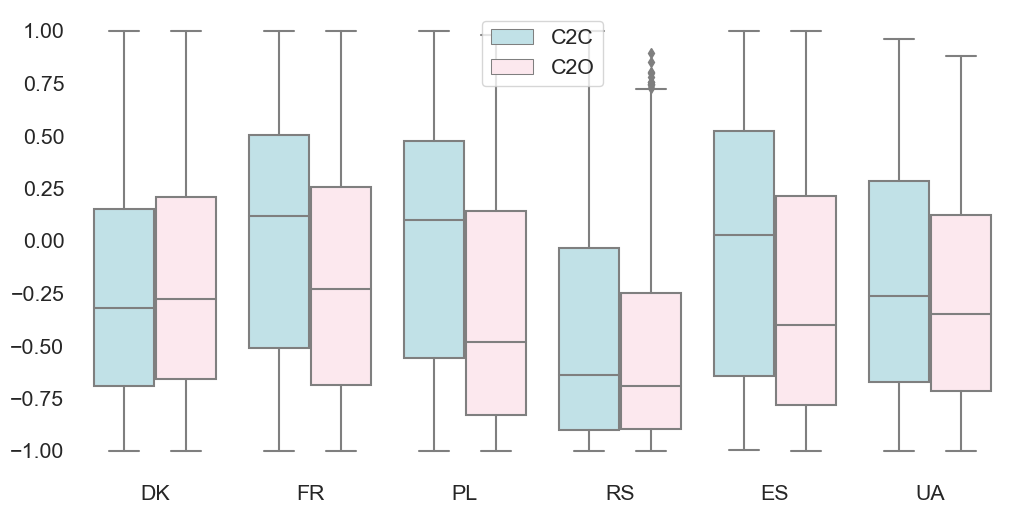

In [34]:
c2_df = specific_df[specific_df['mention_category'].isin(['C2O', 'C2C'])]


plt.figure(figsize=(12, 6))
sns.set(font_scale=1.4)
sns.set_style('white')

ax = sns.boxplot(data=c2_df, x="Parliament", y="sentiment", hue="mention_category", hue_order=['C2C', 'C2O'],
           palette=('#BBE5ED', '#FFE5ED'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(loc='upper center')

plt.xlabel('')
plt.ylabel('')


plt.savefig('./paper_figures/boxplot2.png', dpi=200)

plt.show()


In [35]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

for parliament in parliaments:    
    c2_df_parliament = c2_df[c2_df['Parliament'] == parliament]
    x = c2_df_parliament[c2_df_parliament['mention_category'] == 'C2C']['sentiment'].values
    y = c2_df_parliament[c2_df_parliament['mention_category'] == 'C2O']['sentiment'].values
    print("Parliament: ", parliament)
    print("C2C vs. C2O: ", ks_2samp(x, y))
    
    print("C2C quantiles: ", 
          c2_df_parliament[c2_df_parliament['mention_category'] == 'C2C']['sentiment'].quantile([0.25, 0.5, 0.75]))
    print("C2O quantiles: ",
          c2_df_parliament[c2_df_parliament['mention_category'] == 'C2O']['sentiment'].quantile([0.25, 0.5, 0.75]))

Parliament:  DK
C2C vs. C2O:  KstestResult(statistic=0.035320272925409874, pvalue=0.09603044805424063)
C2C quantiles:  0.25   -0.690918
0.50   -0.318359
0.75    0.152954
Name: sentiment, dtype: float64
C2O quantiles:  0.25   -0.658691
0.50   -0.274902
0.75    0.208221
Name: sentiment, dtype: float64
Parliament:  FR
C2C vs. C2O:  KstestResult(statistic=0.18468508474541667, pvalue=1.841462670703653e-20)
C2C quantiles:  0.25   -0.510742
0.50    0.118134
0.75    0.502808
Name: sentiment, dtype: float64
C2O quantiles:  0.25   -0.686523
0.50   -0.230835
0.75    0.257324
Name: sentiment, dtype: float64
Parliament:  PL
C2C vs. C2O:  KstestResult(statistic=0.25038767087339264, pvalue=3.082331251674953e-30)
C2C quantiles:  0.25   -0.560303
0.50    0.099152
0.75    0.475830
Name: sentiment, dtype: float64
C2O quantiles:  0.25   -0.831055
0.50   -0.481201
0.75    0.140503
Name: sentiment, dtype: float64
Parliament:  RS
C2C vs. C2O:  KstestResult(statistic=0.08667394370061987, pvalue=1.005746037349

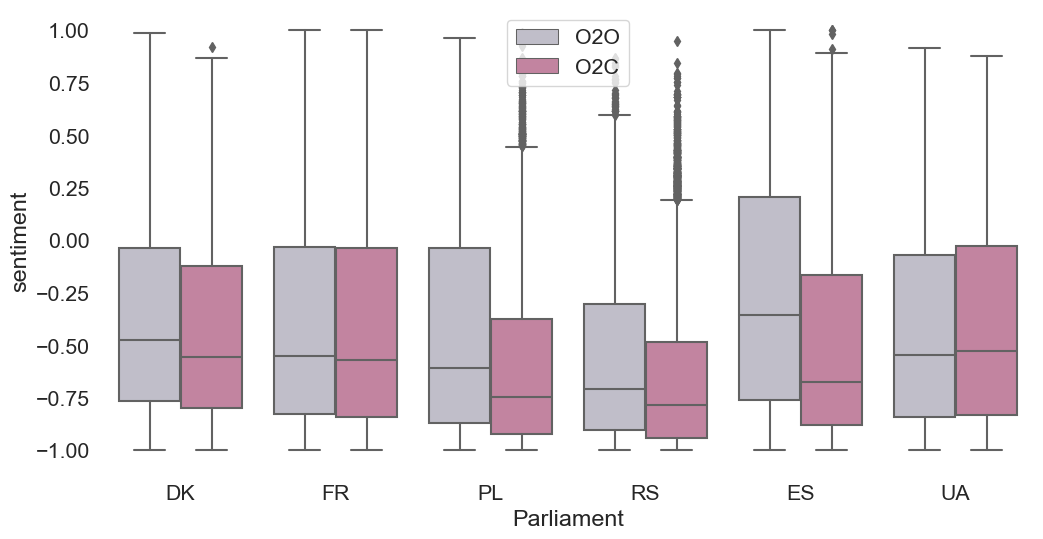

In [37]:
c2_df = specific_df[specific_df['mention_category'].isin(['O2C', 'O2O'])]


plt.figure(figsize=(12, 6))
sns.set(font_scale=1.4)
sns.set_style('white')

ax = sns.boxplot(data=c2_df, x="Parliament", y="sentiment", hue="mention_category", hue_order=['O2O', 'O2C'],
           palette=('#BFBCCB', '#CC7A9F'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(loc='upper center')

plt.savefig('./paper_figures/boxplot3.png', dpi=200)

plt.show()

In [38]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

for parliament in parliaments:    
    c2_df_parliament = c2_df[c2_df['Parliament'] == parliament]
    x = c2_df_parliament[c2_df_parliament['mention_category'] == 'O2O']['sentiment'].values
    y = c2_df_parliament[c2_df_parliament['mention_category'] == 'O2C']['sentiment'].values
    print("Parliament: ", parliament)
    print("O2O vs. O2C: ", ks_2samp(x, y))
    
    print("O2O quantiles: ", 
          c2_df_parliament[c2_df_parliament['mention_category'] == 'O2O']['sentiment'].quantile([0.25, 0.5, 0.75]))
    print("O2C quantiles: ",
          c2_df_parliament[c2_df_parliament['mention_category'] == 'O2C']['sentiment'].quantile([0.25, 0.5, 0.75]))

Parliament:  DK
O2O vs. O2C:  KstestResult(statistic=0.06828142210392221, pvalue=2.6904765188262873e-08)
O2O quantiles:  0.25   -0.767578
0.50   -0.474365
0.75   -0.036743
Name: sentiment, dtype: float64
O2C quantiles:  0.25   -0.800293
0.50   -0.554199
0.75   -0.123917
Name: sentiment, dtype: float64
Parliament:  FR
O2O vs. O2C:  KstestResult(statistic=0.0381984246690129, pvalue=0.4094438273718346)
O2O quantiles:  0.25   -0.825806
0.50   -0.549072
0.75   -0.034180
Name: sentiment, dtype: float64
O2C quantiles:  0.25   -0.839722
0.50   -0.568604
0.75   -0.037483
Name: sentiment, dtype: float64
Parliament:  PL
O2O vs. O2C:  KstestResult(statistic=0.12813905483354446, pvalue=4.495923521476943e-18)
O2O quantiles:  0.25   -0.870117
0.50   -0.607910
0.75   -0.038239
Name: sentiment, dtype: float64
O2C quantiles:  0.25   -0.923706
0.50   -0.748291
0.75   -0.375793
Name: sentiment, dtype: float64
Parliament:  RS
O2O vs. O2C:  KstestResult(statistic=0.09278700106881821, pvalue=2.11360996342782

## General dataset stats

In [40]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

full_df = pd.DataFrame()

for parliament in parliaments:
    df = pd.read_csv('../../data/parliaments/' + parliament + '/metasent_' + parliament + '.csv')
    
    df['Parliament'] = parliament
    
    full_df = pd.concat([full_df, df])

In [52]:
full_df['speech_length'] = full_df['speech_clean'].apply(lambda x: len(x.split()))

In [54]:
full_df

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_birth,speech,speech_clean,sentiment,Parliament,From,To,House,Speaker_type,speech_length
0,ParlaMint-DK_20141007120716,Hansard of the session of the Danish Parliamen...,2014-10-07,Unicameralism,NaN,20141.0,1.0,NaN,NaN,Reference,...,1966.0,Danske kampfly er landet i Kuwait. De skal del...,De skal deltage i den internationale indsats m...,0.304199,DK,NaN,NaN,NaN,NaN,4686
1,ParlaMint-DK_20141009100342,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,Reference,...,1964.0,Politik handler om at forandre – forandre for ...,Derfor har jeg glædet mig rigtig meget til dag...,0.304199,DK,NaN,NaN,NaN,NaN,1377
2,ParlaMint-DK_20141009101322,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,Reference,...,1964.0,Tak for det. Der kommer ikke nogen nulvækstpla...,"Vi har en plan om et udgiftsstop, som betyder,...",0.058502,DK,NaN,NaN,NaN,NaN,90
3,ParlaMint-DK_20141009101422,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,Reference,...,1982.0,"Hvornår kommer planen så? Altså, at hr. Lars L...","Altså, at hr. Lars Løkke Rasmussen leger med o...",-0.857422,DK,NaN,NaN,NaN,NaN,103
4,ParlaMint-DK_20141009101504,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,Reference,...,1964.0,"Vi har jo den samme økonomiske plan, som reger...",Vi har endda hjulpet regeringen med at lave de...,-0.085449,DK,NaN,NaN,NaN,NaN,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60570,ParlaMint-UA_2023-02-24-m0.u169,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2023-02-24,Unicameralism,9,9,NaN,2023-02-24,NaN,War,...,1982.0,"Позиція комітету. Не враховувати цю поправку, ...","Не враховувати цю поправку, тому що в даному в...",-0.691406,UA,NaN,NaN,NaN,NaN,78
60571,ParlaMint-UA_2023-02-24-m0.u173,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2023-02-24,Unicameralism,9,9,NaN,2023-02-24,NaN,War,...,1967.0,"Мороз Володимир. Шановні колеги, питанню про в...","Шановні колеги, питанню про ввезення автомобіл...",0.306152,UA,NaN,NaN,NaN,NaN,136
60572,ParlaMint-UA_2023-02-24-m0.u175,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2023-02-24,Unicameralism,9,9,NaN,2023-02-24,NaN,War,...,1989.0,"Шановні колеги, давайте я поясню, про що цей з...","Зараз головна догма, по якій розмитнюються май...",-0.716309,UA,NaN,NaN,NaN,NaN,221
60573,ParlaMint-UA_2023-02-24-m0.u177,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2023-02-24,Unicameralism,9,9,NaN,2023-02-24,NaN,War,...,1965.0,"Шановні колеги, проблема насправді набагато гл...",Законопроекти 7466 і 68 яскраве тому підтвердж...,-0.984863,UA,NaN,NaN,NaN,NaN,184


In [62]:
full_df.groupby(['Parliament', 'Party_status'])['ID'].count()

Parliament  Party_status
DK          Coalition       38592
            Opposition      59144
ES          Coalition        5235
            Opposition      11272
FR          Coalition       22436
            Opposition      25011
PL          Coalition       17826
            Opposition      34789
RS          Coalition       70625
            Opposition      47239
UA          Coalition       22875
            Opposition      24917
Name: ID, dtype: int64

In [61]:
full_df.groupby(['Parliament', 'Party_status'])['Speaker_name'].nunique()

Parliament  Party_status
DK          Coalition       158
            Opposition      239
ES          Coalition       308
            Opposition      497
FR          Coalition       299
            Opposition      131
PL          Coalition       250
            Opposition      289
RS          Coalition       861
            Opposition      420
UA          Coalition       683
            Opposition      282
Name: Speaker_name, dtype: int64

In [53]:
full_df.groupby('Parliament')['speech_length'].mean()

Parliament
DK    217.772537
ES    695.670141
FR    215.790739
PL    258.934642
RS    524.334635
UA    167.637161
Name: speech_length, dtype: float64

In [57]:
full_df.groupby('Parliament')['Speaker_party'].nunique()

Parliament
DK    19
ES    55
FR    17
PL     9
RS    69
UA    42
Name: Speaker_party, dtype: int64

## Who is more polarizing? Coalition or Opposition?

In [84]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

# Create a new column 'month_year' containing the month-year string
specific_df['month_year'] = specific_df['Date'].dt.strftime('%b-%Y')

In [85]:
specific_df['month_year']

3        Oct-2014
11       Oct-2014
12       Oct-2014
13       Oct-2014
19       Oct-2014
           ...   
60550    Feb-2023
60557    Feb-2023
60562    Feb-2023
60563    Feb-2023
60567    Feb-2023
Name: month_year, Length: 82025, dtype: object

In [114]:
import random

parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

df_differences_data = {
    'Parliament': [],
    'Affective polarization': [],
    'Induced by': []
}

for parliament in parliaments:
    parliament_df = specific_df[specific_df['Parliament'] == parliament]

    C2C_df = parliament_df[parliament_df['mention_category'] == 'C2C']
    C2O_df = parliament_df[parliament_df['mention_category'] == 'C2O']
    O2O_df = parliament_df[parliament_df['mention_category'] == 'O2O']
    O2C_df = parliament_df[parliament_df['mention_category'] == 'O2C']
    
    for i in range(1000):
        
        try:
            date = random.choice(parliament_df.month_year.unique())
            C2C_value = C2C_df[C2C_df['month_year'] == date].sample(1)['sentiment'].values[0]
            C2O_value = C2O_df[C2O_df['month_year'] == date].sample(1)['sentiment'].values[0]
            coalition_difference = C2C_value - C2O_value
            
            O2O_value = O2O_df[O2O_df['month_year'] == date].sample(1)['sentiment'].values[0]
            O2C_value = O2C_df[O2C_df['month_year'] == date].sample(1)['sentiment'].values[0]
            opposition_difference = O2O_value - O2C_value
                
            df_differences_data['Parliament'].append(parliament)
            df_differences_data['Affective polarization'].append(coalition_difference)
            df_differences_data['Induced by'].append('Coalition')
            
            df_differences_data['Parliament'].append(parliament)
            df_differences_data['Affective polarization'].append(opposition_difference)
            df_differences_data['Induced by'].append('Opposition')

        except:
            continue

df_differences = pd.DataFrame(df_differences_data)


In [115]:
df_differences

,Parliament,Affective polarization,Induced by
0,DK,-0.593994,Coalition
1,DK,0.176575,Opposition
2,DK,0.061523,Coalition
3,DK,0.628448,Opposition
4,DK,-0.809692,Coalition
...,...,...,...
9941,UA,-0.116699,Opposition
9942,UA,0.776489,Coalition
9943,UA,-0.321045,Opposition
9944,UA,0.328857,Coalition


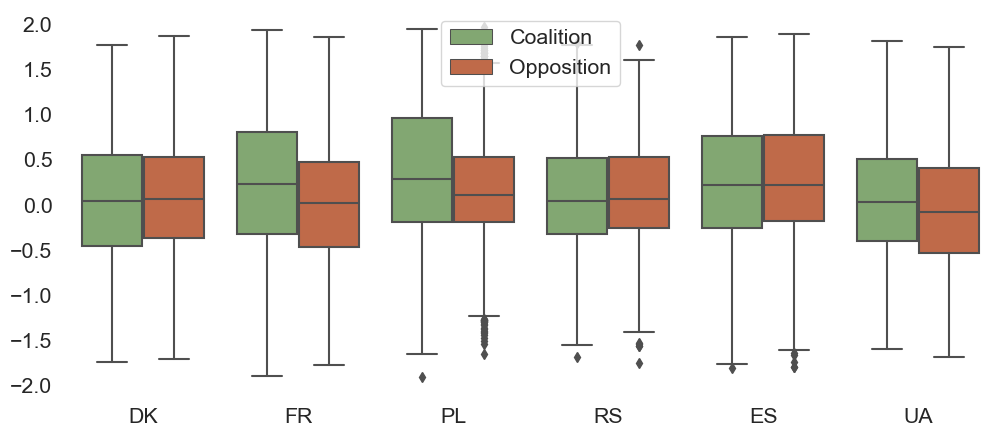

In [124]:
plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
sns.set_style('white')

ax = sns.boxplot(data=df_differences, x="Parliament", y="Affective polarization", hue="Induced by", hue_order=['Coalition', 'Opposition'],
           palette=('#7FB069', '#D36135'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(loc='upper center')



plt.xlabel('')
plt.ylabel('')


plt.savefig('./paper_figures/boxplot4.png', dpi=200)


plt.show()

In [118]:
parliaments = ['DK', 'FR', 'PL', 'RS', 'ES', 'UA']

for parliament in parliaments:    
    df_parliament = df_differences[df_differences['Parliament'] == parliament]
    x = df_parliament[df_parliament['Induced by'] == 'Coalition']['Affective polarization'].values
    y = df_parliament[df_parliament['Induced by'] == 'Opposition']['Affective polarization'].values
    print("Parliament: ", parliament)
    print("Coalition vs. Polarization (affective polarization): ", ks_2samp(x, y))
    
    print("Coalition Affective Polarization quantiles:\n", 
          df_parliament[df_parliament['Induced by'] == 'Coalition']['Affective polarization'].quantile([0.25, 0.5, 0.75]).values)
    print("Opposition Affective Polarization quantiles:\n",
          df_parliament[df_parliament['Induced by'] == 'Opposition']['Affective polarization'].quantile([0.25, 0.5, 0.75]).values)
    print('\n\n')

Parliament:  DK
Coalition vs. Polarization (affective polarization):  KstestResult(statistic=0.06877113866967305, pvalue=0.030111771742025485)
Coalition Affective Polarization quantiles:
 [-0.45874023  0.03808594  0.55540466]
Opposition Affective Polarization quantiles:
 [-0.36645508  0.06347656  0.53326416]



Parliament:  FR
Coalition vs. Polarization (affective polarization):  KstestResult(statistic=0.15217391304347827, pvalue=3.5751198152947776e-10)
Coalition Affective Polarization quantiles:
 [-0.32131958  0.22491455  0.80647278]
Opposition Affective Polarization quantiles:
 [-0.4680481   0.02319336  0.4703064 ]



Parliament:  PL
Coalition vs. Polarization (affective polarization):  KstestResult(statistic=0.15958668197474168, pvalue=4.2811152518508234e-10)
Coalition Affective Polarization quantiles:
 [-0.1862793   0.28393555  0.95568848]
Opposition Affective Polarization quantiles:
 [-0.18969727  0.10400391  0.52320862]



Parliament:  RS
Coalition vs. Polarization (affective pol